In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import cred
import time
import random
import pandas as pd
import seaborn as sns
import numpy as np

scope = "playlist-read-private, playlist-modify-public, user-read-private, user-top-read, user-library-read"
auth_manager = SpotifyOAuth(client_id=cred.client_id, client_secret=cred.client_secret, redirect_uri='http://127.0.0.1:8080', scope=scope)
sp = spotipy.Spotify(auth_manager=auth_manager, requests_timeout=10, retries=5)

user_id = sp.current_user()['id']
user_country = sp.current_user()['country']
username = sp.current_user()['display_name']
if sp.current_user()['explicit_content']['filter_enabled'] or sp.current_user()['explicit_content']['filter_enabled']:
  user_explicit = False
else:
  user_explicit = True


In [ ]:
def get_user_playlist_ids():
  '''
  Collects a list of user playlist dictionaries and the Spotify ID for each of them.
  '''
  playlists_lst =[]
  ids = []
  offset = 0
  while True:
      playlists = sp.current_user_playlists(offset=offset)
      if len(playlists['items']) == 0:
          break
      for playlist in playlists['items']:
          playlists_lst.append(playlist)
      offset = offset + len(playlists['items'])
      time.sleep(0.01) 
  
  for playlist in playlists_lst:
      ids.append(playlist['id'])
  return ids, playlists_lst

def get_saved_tracks():
  '''
  Gets a user's "liked" tracks
  '''
  ids = []
  print('I\'m starting to look at the user\'s saved tracks!!')
  offset = 0
  t1 = time.time()
  while True:
      track_ids = sp.current_user_saved_tracks(offset=offset)
      if len(track_ids['items']) == 0:
          break
      for track in track_ids['items']:
          if track['track'] == None:
              continue
          else:
              ids.append(track['track']['id'])
      offset = offset + len(track_ids['items'])
      time.sleep(0.01)
  t2 = time.time()
  print(f'Hmmm... getting the liked tracks took {t2-t1} seconds!\n')
  return list(set(ids))

def get_playlist_names(playlists):
  '''
  Returns a list of a user's playlist titles when given a list of playlist ids
  '''
  names = []
  for playlist in playlists:
      name = playlist['name']
      names.append(name)
  return names

def get_song_ids_from_playlists(user, playlist_urls):
  '''
  Gets song ids from each of the songs in given playlist ids
  '''
  ids = []
  t1 = time.time()
  for i in range(len(playlist_urls)):
      offset = 0
      print(f'I\'m starting playlist number {i+1} out of {len(playlist_urls)}')
      while True:
          track_ids = sp.user_playlist_tracks(user=user, playlist_id=playlist_urls[i], offset=offset, fields ='items.track.id')
          #print(track_ids)
          #print(len(track_ids['items']))
          if len(track_ids['items']) == 0:
              break
          for track in track_ids['items']:
              if track['track'] == None:
                  continue
              else:
                  ids.append(track['track']['id'])
          offset = offset + len(track_ids['items'])
          time.sleep(0.01)
  t2 = time.time()
  print(f'Getting song ids from all those playlists took {round(t2-t1, 2)} seconds!\n')
  return list(set(ids))

def get_recc_ids(list_seed_tracks, country):
  '''
  Gets ids for # recommended songs for each song in the seed tracks list
  '''
  print('Starting to collect recommendation ids.')
  if len(list_seed_tracks) > 150:
      print(f'Wow! I have {len(list_seed_tracks)*30} to make. This may take a while.\n')
  recc_ids = []
  #raw_recs = []
  t1 = time.time()
  for seed in list_seed_tracks:
      seed_to_use = []
      seed_to_use.append(seed)
      recs = sp.recommendations(seed_tracks=seed_to_use, limit = 30, country=country)
      #raw_recs.append(recs)
      #print(recs)
      for i in range(len(recs['tracks'])):
        track_id = recs['tracks'][i]['id']
        recc_ids.append(track_id)
      #print(len(recc_ids))
  set_ids = set(recc_ids) 
  t2 = time.time()
  print(f'Making and saving all of those recommendations took {round(t2-t1, 2)} seconds.\n')
  return list(set_ids)

def create_playlist(tracks):
  sp.user_playlist_create(user_id, 'your recommended songs', description='yay new songs!')
  user_playlists, y = get_user_playlist_ids()
  sp.user_playlist_add_tracks(user_id, user_playlists[0], tracks)
  return 'Your playlist has been created!'

def create_df(track_ids, in_lib):
  print(f'{len(track_ids)} observations to make!')
  data = []

  for i in range(len(track_ids)):
    # Get raw data for track
    track = sp.track(recc_ids[i])
    features = sp.audio_features(track_ids[i])
    analysis = sp.audio_analysis(track_ids[i])
    artist_uri = track['album']['artists'][0]['uri']
    artist = sp.artist(artist_uri)

    # Extract relevant data
    observation = [
      track['album']['uri'], 
      track['name'],
      in_lib,
      artist['followers']['total'],
      artist['genres'],
      artist['popularity'],
      track['album']['release_date'][0:4], 
      len(track['artists']),
      round(track['duration_ms']/60000, 4),
      track['popularity'],
      features[0]['danceability'],
      features[0]['energy'],
      features[0]['key'],
      analysis['track']['key_confidence'],
      features[0]['loudness'],
      features[0]['mode'],
      analysis['track']['mode_confidence'],
      features[0]['speechiness'],
      features[0]['acousticness'],
      features[0]['acousticness'],
      features[0]['liveness'],
      features[0]['valence'],
      features[0]['tempo'],
      analysis['track']['tempo_confidence'],
      features[0]['time_signature'],
      analysis['track']['time_signature_confidence'],
      analysis['track']['num_samples'],
      len(analysis['bars']),
      len(analysis['beats']),
      len(analysis['sections']),
      len(analysis['segments']), # for each segment, there is a list of pitches and timbre!
      len(analysis['tatums'])
    ]

    # Add observation to total dataset
    data.append(observation)
    time.sleep(0.0001)
    
  # Create final data frame with proper column names
  df = pd.DataFrame(data, columns=[
    'uri', 'track_name', 'in_library', 'artist_followers', 'artist_genres', 'artist_popularity', 'release_date', 
    'nartists', 'duration_m', 'track_popularity', 'danceability', 'energy',
    'key', 'key_conf', 'loudness', 'mode', 'mode_conf', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'tempo_conf', 'time_sig', 'time_sig_conf', 'nsamples', 'nbars',
    'nbeats', 'nsections', 'nsegments', 'ntatums'
  ])

  return df

In [ ]:
# Get all playlist ids and all complete playlist information
playlist_ids, raw_playlists = get_user_playlist_ids()
print(f'Cool! You have {len(playlist_ids)} playlists in your library!')

#playlist_names = get_playlist_names(playlist_ids)

# Extract playlist 1 for testing
testing_playlist = [playlist_ids[0]]

# Get the song ids for all tracks in the test playlist
song_ids = get_song_ids_from_playlists(user_id, testing_playlist)
print(f'Whoa...you have {len(song_ids)} songs in your library (using the playlists provided).')

recc_ids = get_recc_ids(song_ids, user_country)

In [ ]:
recc_df = create_df(recc_ids, 0) # df of recommendations
saved_df = create_df(song_ids, 1) # df of songs in library
combined_df = pd.concat([recc_df, saved_df]) # the previous two combined

#pd.set_option('display.max_columns', None)
#numeric_df = combined_df.select_dtypes(include = 'number')
#numeric_df.drop(labels = ['key_conf',  'tempo_conf', 'time_sig_conf', 'mode_conf', 'key', 'mode', 'time_sig'], axis = 1)

In [162]:
small_df = combined_df[['in_library', 'danceability', 'valence']] # small df for testing
kmeans_df = small_df.drop('in_library', axis = 1) # just numeric variables of the above

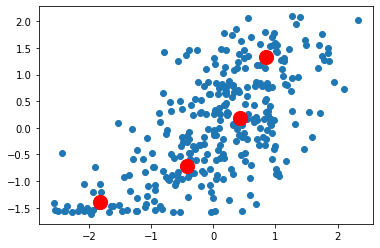

[[1.         0.66837052]
 [0.66837052 1.        ]]


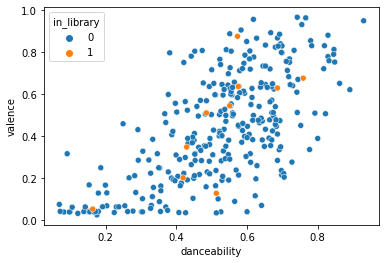

In [166]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

# Standardizes a data frame
# Currently set to two numeric variables for all songs
scaled_data = StandardScaler().fit_transform(kmeans_df)

# Create kmeans model fit to the standardized data
clusters = 4
km = KMeans(n_clusters=clusters).fit(scaled_data)


# Print a plot of the clusters and the cluster centers
plt.scatter(scaled_data[:,0], 
            scaled_data[:,1])
plt.scatter(km.cluster_centers_[:, 0], 
            km.cluster_centers_[:, 1], 
            s=200,                             # Set centroid size
            c='red')                           # Set centroid color
plt.show()
# Scatterplot of two-variable data with correlations
sns.scatterplot(data = small_df, x = 'danceability', y = 'valence', hue = 'in_library')
print(np.corrcoef(small_df['danceability'], small_df['valence']))


# "Predict" clusters for all songs in library (just get the clusters for each liked song)
# Get percentage of liked songs per cluster (outputs an array of cluster nums)
# in the example: 40% from #2 and 60% from #0
# cut back on variables to be able to visualize the clusters
# is anything going wrong that we can't see? (too many songs in the same cluster)
# perhaps some sort of cross-validation? grab 10 other unique songs that aren't in the reccs or lib and see where
#   they fall

In [167]:
from collections import Counter

# Predict clusters for songs in library
in_lib_predict = km.predict(StandardScaler().fit_transform(saved_df[['danceability', 'valence']]))
#print(in_lib_predict)

# Set counts for all clusters to 0 (ensures that all clusters are present)
initial_counts = {}
for i in range(0, clusters):
  initial_counts[i] = 0

# Create a counter and add in predicted cluster counts
cluster_counts = Counter(initial_counts)
cluster_counts.update(in_lib_predict)

# Create new dict with percentages of songs in library that are in each of the clusters
cluster_perc = {}
for item in cluster_counts:
  cluster_perc[item] = round(cluster_counts[item] / len(song_ids), 4)

print(cluster_counts)
print(cluster_perc)

Counter({0: 3, 1: 3, 3: 3, 2: 1})
{0: 0.3, 1: 0.3, 2: 0.1, 3: 0.3}


Text(0.5, 1.0, 'Elbow curve')

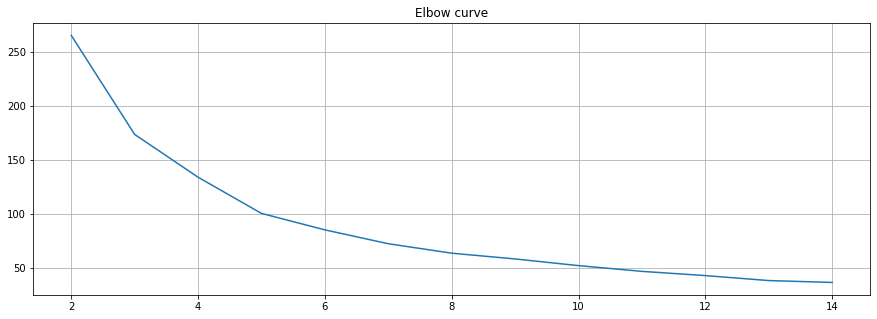

In [165]:
# Elbow Plot
distortions = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_data)
    distortions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 15), distortions)
plt.grid(True)
plt.title('Elbow curve')